
# Support Vector Machines on the D-Wave Quantum Annealer
#### Created by Gabriele Cavallaro (g.cavallaro@fz-juelich.de)

### 0. Setting Up the Access to the D-Wave 2000Q quantum computer

- Make a free account to run on the D-Wave through [Leap](https://www.dwavesys.com/take-leap)

- Install Ocean Software with [pip install dwave-ocean-sdk](https://docs.ocean.dwavesys.com/en/latest/overview/install.html)

- Configuring the D-Wave System as a Solver with [dwave config create](https://docs.ocean.dwavesys.com/en/latest/overview/dwavesys.html#dwavesys)




### 1. Data Preparation

#### 1.1 Load of the Python Modules

In [2]:
from utils import * # It contains functions for threat the data (I/O, encoding/decoding) and metrics for evaluations 

#### 1.2 Select the Dataset

##### In this notebook we consider the datasets of [HyperLabelMe](http://hyperlabelme.uv.es/index.html) (i.e., a benchmark system for remote sensing image classification). 

- It contains 43 image datasets, both multi- and hyperspectral
- For each one, training pairs (spectra and their labels) and test spectra are provided
- The test labels are not given. The predicted labels needs to be uploaded in HyperLabelMe which will return the accuracy


In [3]:
# Load the data
# in this instance gamma represents the number of features in the dataset
gamma=2

id_dataset='MNIST56'
[X_train,X_test, Y_train, Y_test ]=load(id_dataset, gamma)

loading dataset MNIST with classes '5' and '6'


2023-11-22 11:50:50.204993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 11:50:50.205444: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 11:50:50.205486: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 11:50:51.549035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


25.4% of total variance is explained by 2 principal components


In [3]:
# #visualize the training set and test set
# train = list(map(list, zip(*X_train)))
# test = list(map(list, zip(*X_test)))
# plt.figure(figsize=(5,6))
# sns.scatterplot(x = train[0],y = train[1], hue=Y_train)#, style=Y_predicted)
# plt.show()
# plt.figure(figsize=(5,6))
# plt.title("AAAAAAAAAAAA")
# sns.scatterplot(x = test[0],y = test[1], hue=Y_test)#, style=Y_predicted)
# plt.show()


# def loaddd(datakey):
#     dataset = np.loadtxt(datakey, dtype=float, skiprows=1)
#     return dataset[:,2:], dataset[:,1]  # data, labels

# for a in range(4):
#     path = f"input_datasets/calibration/{id_dataset}/{id_dataset}calibtrain{a}"
#     traion_data, train_labels = loaddd(path)
#     print(path)
    
#     traion_data = list(map(list, zip(*traion_data)))
    
#     plt.figure(figsize=(5,6))

#     sns.scatterplot(x = traion_data[0],y = traion_data[1], hue=train_labels)#, style=Y_predicted)
#     plt.show()

print(X_test.shape)

(200, 2)


#### 1.3 Background on Support Vector Machines (SVMs)

A SVM learns its parameters from a set of annotated training samples

- $D=\left\{\textbf{x}_{n}, y_{n}: n=0, \ldots, N-1\right\}$
- with $\textbf{x}_{n} \in \mathbb{R}^{d}$ being a feature vector and $y_n$ its label. 

A SVM separates the samples of different classes in their feature space by tracing maximum margin hyperplanes.

The training consists of solving a [quadratic programming (QP)](https://www.cambridge.org/us/academic/subjects/mathematics/numerical-recipes/numerical-recipes-art-scientific-computing-3rd-edition?format=HB&utm_source=shortlink&utm_medium=shortlink&utm_campaign=numericalrecipes) problem.


\begin{equation}
\label{eq:qp_equation}
L=\frac{1}{2} \sum_{n m} \alpha_{n} \alpha_{m} y_{n} y_{m} k\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)-\sum_{n} \alpha_{n} \qquad \qquad \qquad \text { (1) }
\end{equation}



\begin{equation}
\label{eq:svm_constrains}
\text {subject to} \quad 0 \leq \alpha_{n} \leq C  \> \> \text { and } \> \> \sum_{n} \alpha_{n} y_{n}=0 \qquad  \qquad  \text { (2) }
\end{equation}


For $N$ coefficients $\alpha_{n} \in \mathbb{R}$, where $C$ is a regularization parameter and $k(.,.)$ is a kernel function that enables a SVM to compute non-linear decision functions (by means of the kernel trick 
[kernel trick](https://dl.acm.org/citation.cfm?id=559923)). 
The type of kernel function which is most commonly used is the RBF:
$\operatorname{rbf}\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)=e^{-\overline{\gamma}\left\|\mathbf{x}_{n}-\mathbf{x}_{m}\right\|^{2}}$.

The SVM decision boundary is based on the samples corresponding to $\alpha_{n} \neq 0$ (i.e., support vectors).
A typical solution often contains many $\alpha_{n}=0$. 
The prediction for an arbitrary
sample $\mathbf{x} \in \mathbb{R}^{d}$ can be made by evaluating the decision function (i.e., signed distance between the sample $\mathbf{x}$ and the decision boundary)


\begin{equation}
\label{eq:decision_function}
f(\mathbf{x})=\sum_{n} \alpha_{n} y_{n} k\left(\mathbf{x}_{n}, \mathbf{x}\right)+b \qquad  \qquad  \text { (3) }
\end{equation}

where the bias $b$ can be computed by

\begin{equation}
b=\frac{\sum_{n} \alpha_{n}\left(C-\alpha_{n}\right)\left[y_{n}-\sum_{m} \alpha_{m} y_{m} k\left(\mathbf{x}_{m}, \mathbf{x}_{n}\right)\right]}{\sum_{n} \alpha_{n}\left(C-\alpha_{n}\right)} \qquad  \qquad  \text { (4) }
\end{equation}

The class label for $\mathbf{x}$ predicted  is $\widetilde{y}=\operatorname{sign}(f(\mathbf{x}))$. 


#### 1.4 Quantum SVM

The DW2000Q QA requires the SVM training to be formulated as a [Quadratic Unconstrained Binary Optimization (QUBO)](https://docs.dwavesys.com/docs/latest/c_gs_3.html) problem which is defined as the minimization of the energy function:

\begin{equation}
E=\sum_{i \leq j} a_{i} Q_{i j} a_{j} \qquad  \qquad  \text { (5) }
\end{equation}

with $a_{i} \in\{0,1\}$ the binary variables of the optimization problem, and $Q$ 
the QUBO weight matrix (i.e., an upper-triangular matrix of real numbers).

Since the solution of Eqs. (1)-(2) consists of real numbers $\alpha_{n} \in \mathbb{R}$ and Eq.(4) can only computes discrete solutions, the following encoding is used: 

\begin{equation}
\label{eq:encoding}
\alpha_{n}=\sum_{k=0}^{K-1} B^{k} a_{K n+k} \qquad  \qquad  \text { (6) }
\end{equation}

where $a_{K n+k} \in\{0,1\}$ are binary variables, $K$ is the number of
binary variables to encode $\alpha_{n}$, and $B$ is the base used for the
encoding. 


The formulation of the QP of Eqs. (1)-(2) as QUBO is obtained through the encoding of Eq. (6) and the introduction of a multiplier $\xi$ to include the first constraint of Eq. (2) as a squared penalty term:


\begin{equation}
\label{eq:formulation_qp_quantum_1}
E=\frac{1}{2} \sum_{n m k j} a_{K n+k} a_{K m+j} B^{k+j} y_{n} y_{m} k\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)
-\sum_{n k} B^{k} a_{K n+k}+\xi\left(\sum_{n k} B^{k} a_{K n+k} y_{n}\right)^{2}  \qquad  \qquad  \text { (7) }
\end{equation}

\begin{equation}
\label{eq:formulation_qp_quantum_2}
 =\sum_{n, m=0}^{N-1} \sum_{k, j=0}^{K-1} a_{K n+k} \widetilde{Q}_{K n+k, K m+j} a_{K m+j}   \qquad  \qquad  \text { (8) }
\end{equation}


where $\widetilde{Q}$ is a matrix of size $K N \times K N$ given by 

\begin{equation}
\label{eq:q_embedding}
\widetilde{Q}_{K n+k, K m+j} =\frac{1}{2} B^{k+j} y_{n} y_{m}\left(k\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)+\xi\right)  -\delta_{n m} \delta_{k j} B^{k}   \qquad  \qquad  \text { (9) }
\end{equation}



Since $\widetilde{Q}$ is symmetric, the upper-triangular \ac{QUBO} matrix $Q$ is defined by 
$Q_{i j}=\widetilde{Q}_{i j}+\widetilde{Q}_{j i}$ for $i<j$ and $Q_{i i}=\widetilde{Q}_{i i}$. The second constraint of Eq. (2) is automatically included in Eq. (8) through the encoding given in Eq. (6), since the maximum for $\alpha_{n}$ is given by 

\begin{equation}
C=\sum_{k=1}^{K} B^{k}  \qquad  \qquad  \text { (10) }
\end{equation}

The last step required to run the optimization on the DW2000Q QA is the embedding procedure.
This is necessary because the QUBO problem given in Eq. (5) includes some couplers $Q_{i,j}\neq0$ between qubit $i$ and qubit $j$ for which no physical connection exists on the chip (i.e., constraint of the Chimera topology of the DW2000Q quantum processor).
The embedding increases the number of logical connections between the qubits.
When no embedding can be found, the number of nonzero couplers $n_{cpl}$ is the parameter that can be reduced until an embedding is found. 

The DW2000Q QA computes a variety of close-to-optimal solutions (i.e., different coefficients  $\{\alpha_{n}\}^{(i)}$ obtained from Eq. (6)). Many of these solutions may have a slightly higher
energy than the global minimum $\{\alpha_{n}\}^*$ that can be found by the classical SVM. However, these solutions can still solve the classification problem for the training data.
For each run on the DW2000Q QA, the 20 lowest energy samples from 10,000 reads are kept.


#### 1.5 Quantum SVM: Calibration Phase

The SVM on the QA depends on four hyperparameters:
the encoding base $B$, the number $K$ of qubits per coefficient $\alpha_{n}$, the multiplier $\xi$, and the kernel parameter $\gamma$. The parameter $n_{cpl}$ varies for each run  and is not a parameter of the SVM itself. 

The hyperparameters are selected through a 10-fold cross-validation. Each training set includes only 30 samples (i.e., choice due to the limitations of the QA). The validation includes the remaining samples that are used for the evaluation of the performance.  

For each dataset, the values are calibrated by evaluating the SVM for $B \in \{2, 3, 5, 10\}$, $K\in \{2, 3\}$, $\xi \in \{0, 1, 5\}$, and $\gamma\in \{ −1, 0.125, 0.25, 0.5, 1, 2, 4, 8 \}$. 



In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# 10-fold Monte Carlo (or split-and-shuffle) cross-validation
fold=4

for i in range(0,fold):
    X_train_cal, X_val_cal, Y_train_cal, Y_val_cal = train_test_split(X_train,Y_train, test_size=0.6, random_state=i)
    
    # Pre-processing 
    # X_train_cal = preprocessing.scale(X_train_cal)
    # X_val_cal = preprocessing.scale(X_val_cal)
    a = list(map(list, zip(*X_train_cal)))
    

   # Write the data
    write_samples(X_train_cal, Y_train_cal,'input_datasets/calibration/'+id_dataset+'/'+id_dataset+'calibtrain'+str(i))
    write_samples(X_val_cal, Y_val_cal,'input_datasets/calibration/'+id_dataset+'/'+id_dataset+'calibval'+str(i))
    
print('Each training set includes '+str(X_train_cal.shape[0])+ ' samples')
print('Each validation set includes '+str(X_val_cal.shape[0])+ ' samples')

Each training set includes 120 samples
Each validation set includes 180 samples


In [5]:
from quantum_SVM import *

# Hyperparameters 
K=[2,3]
B=[2, 10]
xi=[1,2]
n_experiments=len(B)*len(K)*len(xi)


In [6]:

hyperparameters=np.zeros([n_experiments,4], dtype=float)

path_data_key='input_datasets/calibration/'+id_dataset+'/'
data_key = id_dataset+'calibtrain'
path_out='outputs/calibration/'+id_dataset+'/'

trainacc=np.zeros([fold], dtype=float)
trainauroc=np.zeros([fold], dtype=float)
trainauprc=np.zeros([fold], dtype=float)
    
testacc=np.zeros([fold], dtype=float)
testauroc=np.zeros([fold], dtype=float)
testauprc=np.zeros([fold], dtype=float)

trainacc_all=np.zeros([n_experiments], dtype=float)
trainauroc_all=np.zeros([n_experiments], dtype=float)
trainauprc_all=np.zeros([n_experiments], dtype=float)
    
testacc_all=np.zeros([n_experiments], dtype=float)
testauroc_all=np.zeros([n_experiments], dtype=float)
testauprc_all=np.zeros([n_experiments], dtype=float)


f = open(path_out+'calibration_results.txt',"w") 
f.write("B\t K\t xi\t   gamma\t trainacc\t trainauroc\t trainauprc\t testacc\t testauroc\t testauprc\n") 
  
count=0 
for x in range(0,len(B)):
    for y in range(0,len(K)):
        for z in range(0,len(xi)):
            for i in range(0,1): # here the author loop over gamma that is fixed in our implementation
                for j in range(0,fold):
                    path=gen_svm_qubos(B[x],K[y],xi[z],gamma,path_data_key,data_key+str(j),path_out)
                    pathsub=dwave_run(path_data_key,path)
                    [trainacc[j],trainauroc[j],trainauprc[j],testacc[j],testauroc[j],testauprc[j]]=eval_run_rocpr_curves(path_data_key,pathsub,'noplotsave')
                    
                hyperparameters[count,0]=B[x]
                hyperparameters[count,1]=K[y]
                hyperparameters[count,2]=xi[z]
                hyperparameters[count,3]=gamma
            
                trainacc_all[count]=np.average(trainacc)
                trainauroc_all[count]=np.average(trainauroc)
                trainauprc_all[count]=np.average(trainauprc)
    
                testacc_all[count]=np.average(testacc)
                testauroc_all[count]=np.average(testauroc)
                testauprc_all[count]=np.average(testauprc)
                
                np.save(path_out+'hyperparameters', hyperparameters)
                np.save(path_out+'trainacc_all', trainacc_all)
                np.save(path_out+'trainauroc_all', trainauroc_all)
                np.save(path_out+'trainauprc_all', trainauprc_all)
                np.save(path_out+'testacc_all', testacc_all)
                np.save(path_out+'testauroc_all', testauroc_all)
                np.save(path_out+'testauprc_all', testauprc_all)
                
                f.write(f'{B[x]}\t {K[y]}\t {xi[z]}\t {gamma:8.3f}\t {np.average(trainacc):8.4f}\t {np.average(trainauroc):8.4f}\t {np.average(trainauprc):8.4f}\t {np.average(testacc):8.4f}\t {np.average(testauroc):8.4f}\t {np.average(testauprc):8.4f}')
                f.write("\n") 
                count=count+1
                
f.close() 

Creating the QUBO of size (240, 240)
Extracting nodes and couplers
Saving 240 nodes and 28680 couplers for outputs/calibration/MNIST56/runMNIST56calibtrain0_B=2_K=2_xi=1_gamma=2/
running outputs/calibration/MNIST56/runMNIST56calibtrain0_B=2_K=2_xi=1_gamma=2/result_couplers=28680/ with 240 nodes and 28680 couplers
 -- no embedding found, removing outputs/calibration/MNIST56/runMNIST56calibtrain0_B=2_K=2_xi=1_gamma=2/result_couplers=28680/ and trying less couplers
running outputs/calibration/MNIST56/runMNIST56calibtrain0_B=2_K=2_xi=1_gamma=2/result_couplers=2500/ with 240 nodes and 2500 couplers
idx   	sum_antn	trainacc	trainauroc	trainauprc	testacc  	testauroc	testauprc
0	  6.0000	  0.8917	  0.9777	  0.9753	  0.8944	  0.9544	  0.9501
Creating the QUBO of size (240, 240)
Extracting nodes and couplers
Saving 240 nodes and 28680 couplers for outputs/calibration/MNIST56/runMNIST56calibtrain1_B=2_K=2_xi=1_gamma=2/
running outputs/calibration/MNIST56/runMNIST56calibtrain1_B=2_K=2_xi=1_gamma=2

idx   	sum_antn	trainacc	trainauroc	trainauprc	testacc  	testauroc	testauprc
0	 25.0000	  0.9333	  0.9744	  0.9759	  0.9167	  0.9731	  0.9679
Creating the QUBO of size (360, 360)
Extracting nodes and couplers
Saving 360 nodes and 64620 couplers for outputs/calibration/MNIST56/runMNIST56calibtrain3_B=2_K=3_xi=2_gamma=2/
running outputs/calibration/MNIST56/runMNIST56calibtrain3_B=2_K=3_xi=2_gamma=2/result_couplers=64620/ with 360 nodes and 64620 couplers
 -- no embedding found, removing outputs/calibration/MNIST56/runMNIST56calibtrain3_B=2_K=3_xi=2_gamma=2/result_couplers=64620/ and trying less couplers
running outputs/calibration/MNIST56/runMNIST56calibtrain3_B=2_K=3_xi=2_gamma=2/result_couplers=2500/ with 360 nodes and 2500 couplers
idx   	sum_antn	trainacc	trainauroc	trainauprc	testacc  	testauroc	testauprc
0	  5.0000	  0.9167	  0.9597	  0.9607	  0.9000	  0.9205	  0.8908
Creating the QUBO of size (240, 240)
Extracting nodes and couplers
Saving 240 nodes and 28680 couplers for outputs/

idx   	sum_antn	trainacc	trainauroc	trainauprc	testacc  	testauroc	testauprc
0	 12.0000	  0.6750	  0.7860	  0.7796	  0.6611	  0.7673	  0.8030
Creating the QUBO of size (240, 240)
Extracting nodes and couplers
Saving 240 nodes and 28680 couplers for outputs/calibration/MNIST56/runMNIST56calibtrain0_B=10_K=2_xi=2_gamma=2/
running outputs/calibration/MNIST56/runMNIST56calibtrain0_B=10_K=2_xi=2_gamma=2/result_couplers=28680/ with 240 nodes and 28680 couplers
 -- no embedding found, removing outputs/calibration/MNIST56/runMNIST56calibtrain0_B=10_K=2_xi=2_gamma=2/result_couplers=28680/ and trying less couplers
running outputs/calibration/MNIST56/runMNIST56calibtrain0_B=10_K=2_xi=2_gamma=2/result_couplers=2500/ with 240 nodes and 2500 couplers
idx   	sum_antn	trainacc	trainauroc	trainauprc	testacc  	testauroc	testauprc
0	-27.0000	  0.7750	  0.8555	  0.8617	  0.7389	  0.8357	  0.8520
Creating the QUBO of size (240, 240)
Extracting nodes and couplers
Saving 240 nodes and 28680 couplers for outp

#### 1.6 Quantum SVM: Training Phase

To overcome the problem of the limited connectivity of the Chimera graph of the DW2000Q QA the whole training set is split into small disjoint subsets $D^{(train,l)}$ of $~40$ samples, with $l=0,...,int(N/40)$. 
The strategy is to build an ensemble of quantum weak SVMs (qeSVMs) where each classifier is trained on $D^{(train,l)}$. 
This is achieved in two steps. First, for each subset $D^{(train,l)}$ the twenty best solutions from the DW2000Q QA (i.e., qSVM$(B, K, \xi , \gamma )\#i$ for $i =0, ... ,19$) are combined by averaging over the respective decision functions $f^{l,i}(\mathbf{x})$ (see Eq. (3)). 

Since the decision function is linear in the coefficients
and the bias $b^{(l,i)}$ is computed from $\alpha_{n}^{(l,i)}$ via Eq. (4), this procedure effectively results in one classifier with an effective set of coefficients 
$\alpha_{n}^{(l)}=\sum_{i} \alpha_{n}^{(l, i)} / 20$ and bias 
$b^{l}=\sum_{i} b^{(l, i)} / 20$.
Second, an average is made over the $int(N/40)$ subsets. 

Note, however, that the data points 
$\left(\mathbf{x}_{n}^{(l)}, y_{n}^{(l)}\right) \in D^{(\text {train }, l)}$ are now different for each $l$. The full decision function is

\begin{equation}
F(\mathbf{x})=\frac{1}{L} \sum_{n l} \alpha_{n}^{(l)} y_{n}^{(l)} k\left(\mathbf{x}_{n}^{(l)}, \mathbf{x}\right)+b,
\end{equation}

where $b=\sum_{l} b^{(l)} / L$. As before, the decision for the class label of a point $\mathbf{x}$ is obtained through $\widetilde{t}=\operatorname{sign}(F(\mathbf{x}))$. 


In [7]:
from quantum_SVM import *
import numpy as np
from utils import *
from sklearn.model_selection import KFold
from sklearn import preprocessing

# Write the data
experiments=4
slice=50 # Number of samples to use for the training
fold=int(len(X_train)/slice)

print(fold)
 
for i in range(0,experiments):    
    cv = KFold(n_splits=fold, random_state=i, shuffle=True)
    count=0
    for test_index, train_index in cv.split(X_train):
        #print("Train Index: ", len(train_index), "\n")
        
        X_train_slice, y_train_slice = X_train[train_index], Y_train[train_index]
        #X_train_slice = preprocessing.scale(X_train_slice)
        
        X_test_slice, y_test_slice = X_train[test_index], Y_train[test_index]
        #X_test_slice = preprocessing.scale(X_test_slice)
        
        write_samples(X_train_slice, y_train_slice,f'input_datasets/train/'+id_dataset+'/'+id_dataset+'calibtrain'+str(i)+'_'+str(count))
        write_samples(X_test_slice, y_test_slice,f'input_datasets/train/'+id_dataset+'/'+id_dataset+'calibval'+str(i)+'_'+str(count))
        
        count=count+1

print("Each training set has", len(train_index), "samples\n")

6
Each training set has 50 samples



In [8]:
# Get the calibration results
path_out='outputs/calibration/'+id_dataset+'/'
hyperparameters=np.load(path_out+'hyperparameters.npy')
testauprc_all=np.load(path_out+'testauprc_all.npy')

# Select the best hyperparameter set for the max value of testauprc
idx_max = np.where(testauprc_all == np.amax(testauprc_all))
B=int(hyperparameters[int(idx_max[0]),0])
K=int(hyperparameters[int(idx_max[0]),1])
xi=int(hyperparameters[int(idx_max[0]),2])
gamma=hyperparameters[int(idx_max[0]),3]
print('The best hyperparameters are:\n'+'B = '+str(B)+' K = '+str(K)+' xi = '+str(xi)+' gamma = '+str(gamma))

path_data_key='input_datasets/train/'+id_dataset+'/'
data_key = id_dataset+'calibtrain'
path_out='outputs/train/'+id_dataset+'/'

trained_SVMs=[]

for j in range(0,experiments):
    for i in range(0,fold):
        path=gen_svm_qubos(B,K,xi,gamma,path_data_key,data_key+str(j)+'_'+str(i),path_out)
        trained_SVMs.append(dwave_run(path_data_key,path))
        np.save(path_out+'trained_SVMs',trained_SVMs)   

The best hyperparameters are:
B = 2 K = 2 xi = 2 gamma = 2.0
Creating the QUBO of size (100, 100)
Extracting nodes and couplers
Saving 100 nodes and 4950 couplers for outputs/train/MNIST56/runMNIST56calibtrain0_0_B=2_K=2_xi=2_gamma=2.0/
running outputs/train/MNIST56/runMNIST56calibtrain0_0_B=2_K=2_xi=2_gamma=2.0/result_couplers=4950/ with 100 nodes and 4950 couplers
Creating the QUBO of size (100, 100)
Extracting nodes and couplers
Saving 100 nodes and 4950 couplers for outputs/train/MNIST56/runMNIST56calibtrain0_1_B=2_K=2_xi=2_gamma=2.0/
running outputs/train/MNIST56/runMNIST56calibtrain0_1_B=2_K=2_xi=2_gamma=2.0/result_couplers=4950/ with 100 nodes and 4950 couplers
Creating the QUBO of size (100, 100)
Extracting nodes and couplers
Saving 100 nodes and 4950 couplers for outputs/train/MNIST56/runMNIST56calibtrain0_2_B=2_K=2_xi=2_gamma=2.0/
running outputs/train/MNIST56/runMNIST56calibtrain0_2_B=2_K=2_xi=2_gamma=2.0/result_couplers=4950/ with 100 nodes and 4950 couplers
Creating the QU

In [9]:
# from quantum_SVM import *
# import numpy as np
# from utils import *
# path_data_key='input_datasets/train/'+id_dataset+'/'
# data_key = id_dataset+'calibtrain'

# [trainacc[j],trainauroc[j],trainauprc[j],testacc[j],testauroc[j],testauprc[j]]=eval_run_rocpr_curves(path_data_key,'outputs/train/im16/runim16calibtrain0_0_B=2_K=3_xi=1_gamma=0.25/result_couplers=2000/','saveplot')

#### 1.7 Quantum SVM: Test Phase
 
The performance of the qeSVMs can be evaluated directly on [HyperLabelMe](http://hyperlabelme.uv.es/index.html) by uploading the predictions (i.e., output file of the next cell)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
[-1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -1. -1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1. -1. -1. -1.
  1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1.
  1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1.  1. -1.
 -1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1.  1.
  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.
 -1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1.
 -1. -1.  1.  1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1.  1. -1. -1.  1.
  1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1.
 -1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1. -1.  1.  1.  1.  1.
  1. -1.]
[-1  1 -1  1  1  1 -1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1 -1  1  1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1  1

0.875

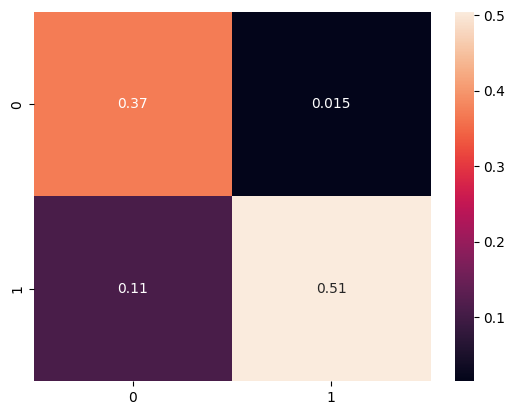

In [4]:
from quantum_SVM import *
from sklearn import preprocessing

# Pre-processing the test spectra


path_data_key='input_datasets/train/'+id_dataset+'/'
data_key = id_dataset+'calibtrain'
path_train_out='outputs/train/'+id_dataset+'/'
path_test_out='outputs/test/'+id_dataset+'/'

path_files=np.load(path_train_out+'trained_SVMs.npy')

experiments=4
slices=6
scores=[]
for j in range(0,experiments):
    for i in range(0,slices):
        scores.append(predict(path_data_key, [i],X_test))
 
avg_scores=np.zeros((scores[0].shape[0]))
Y_predicted=np.zeros((scores[0].shape[0]),int)
    
for i in range(0,scores[0].shape[0]):
    tmp=0
    for y in range(0,slices):
        tmp=tmp+np.sign(scores[y][i])
    avg_scores[i]=tmp   


# for i in range(0,scores[0].shape[0]):
#     tmp=0
#     for y in range(0,slices):
#         tmp=tmp+scores[y][i]
#     avg_scores[i]=tmp/slices   
 

for i in range(0,scores[0].shape[0]):
    if(avg_scores[i]<0):
        Y_predicted[i]=-1
    else:
        Y_predicted[i]=1
        

from sklearn.metrics import accuracy_score
print(Y_test)
print(Y_predicted)
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(Y_predicted, Y_test)/len(Y_predicted),annot=True)
accuracy_score(Y_predicted, Y_test)
#datawrite(path_test_out,'qeSVM', id_dataset, Y_predicted)